# BIT数据挖掘-分类与预测

## 数据集：Hotel booking demand

数据描述：

    hotel

酒店

    is_canceled

是否取消预定

    lead_time

从预定到抵达酒店的时长（天）

    arrival_date_year

到达酒店时的年份

    arrival_date_month

到达酒店时的月份

    arrival_date_week_number

到达酒店时的周数

    arrival_date_day_of_month

到达酒店时是本月第几天

    stays_in_weekend_nights

待在周末晚上的时间

    stays_in_week_nights

待在工作日晚上的时间

    adults

成人数量

    children

儿童数量

    babies

婴儿数量

    meal

午餐（Undefined/SC -无餐套餐；BB-住宿加早餐酒店；HB-半膳(早餐和另一顿饭，通常是晚餐)；FB-全食）

    country

国家

    market_segment

市场细分

    distribution_channel
    
预定渠道

    is_repeated_guest
    
是否是常客

    previous_cancellations
    
以前是否取消过

    previous_bookings_not_canceled
    
以前预定前未取消先前预定

    reserved_room_type
    
保留房间类型

    assigned_room_type
    
指定房间类型

    booking_changes
    
从预订到入住或取消前是否变更

    deposit_type
    
定金类型

    agent
    
预定旅行社的ID

    company
    
由预定或支付的实体公司ID

    days_in_waiting_list
    
在预定确认前等待时长

    customer_type
    
客人类型

    adr
    
平均房价，定义：住宿交易/住宿时长

    required_car_parking_spaces
    
客人停车需求

    total_of_special_requests
    
是否有特殊需求

    reservation_status
    
预定状态

    reservation_status_date
    
状态更新日期

### 1. 数据读取

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv("hotel_bookings/hotel_bookings.csv")
data.shape

(119390, 32)

In [3]:
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
hotel                             119390 non-null object
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119386 non-null float64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           118902 non-null object
market_segment                    119390 non-null object
distribution_channel              119390 n

In [5]:
data.isnull().sum()[data.isnull().sum()!=0]

children         4
country        488
agent        16340
company     112593
dtype: int64

初步分析有32列数据，其中存在有缺失值，有children、contry、agent、company。

### 2. 数据清洗

其中有四项信息存在缺失值，company缺失较多，考虑删除，children和country、agent缺失较少，考虑填充。

处理方法：

* 假设agent中缺失值代表未指定任何机构，nan=0
* country则直接使用其字段内众数填充
* children使用其字段内众数填充
* company因缺失数值过大，且其信息较杂（单个值分布太多），所以直接删除

In [6]:
# 删除company列
data_new = data.copy(deep = True)
data_new.drop("company", axis=1, inplace=True)

In [7]:
# 对其余缺失值进行填充
data_new["agent"].fillna(0, inplace=True)
data_new["children"].fillna(data_new["children"].mode()[0], inplace=True)
data_new["country"].fillna(data_new["country"].mode()[0], inplace=True)

In [8]:
# 再次查看数据新形象
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 31 columns):
hotel                             119390 non-null object
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119390 non-null float64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           119390 non-null object
market_segment                    119390 non-null object
distribution_channel              119390 n

异常值处理：
数据集中异常值为那些总人数（adults+children+babies)为0的记录

同时，因为先前已指名“meal”中“SC”和“Undefined”为同一类别，所以也需要处理一下。

In [9]:
data_new["children"] = data_new["children"].astype(int)
data_new["agent"] = data_new["agent"].astype(int)

data_new["meal"].replace("Undefined", "SC", inplace=True)
# 处理异常值
# 将变量 adults + children + babies == 0 的数据删除
zero_guests = list(data_new["adults"] +
                  data_new["children"] +
                  data_new["babies"] == 0)
data_new.drop(data_new.index[zero_guests], inplace=True)

### 3. 数据探索性分析

#### 3.1 城市酒店和假日酒店预定需求以及入住率比较

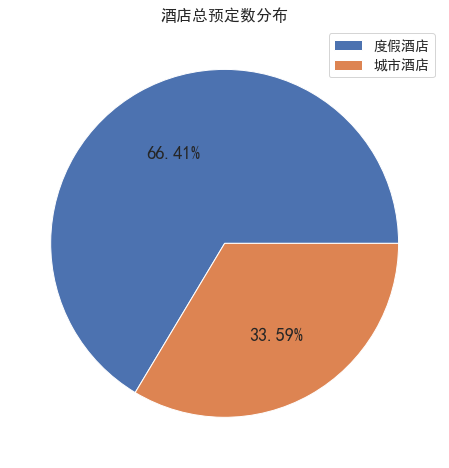

In [10]:
plt.rcParams['font.sans-serif']=['simhei']   # 用黑体显示中文
plt.rcParams['axes.unicode_minus']=False     # 正常显示负号
# 从预定是否取消考虑
rh_iscancel_count = data_new[data_new["hotel"]=="Resort Hotel"].groupby(["is_canceled"])["is_canceled"].count()
ch_iscancel_count = data_new[data_new["hotel"]=="City Hotel"].groupby(["is_canceled"])["is_canceled"].count()

rh_cancel_data = pd.DataFrame({"hotel": "度假酒店",
                              "is_canceled": rh_iscancel_count.index,
                              "count": rh_iscancel_count.values})

ch_cancel_data = pd.DataFrame({"hotel": "城市酒店",
                              "is_canceled": ch_iscancel_count.index,
                              "count": ch_iscancel_count.values})
iscancel_data = pd.concat([rh_cancel_data, ch_cancel_data], ignore_index=True)

plt.figure(figsize=(8, 8))
w, t, autotexts = plt.pie(data_new["hotel"].value_counts(), autopct="%.2f%%",textprops={"fontsize":18})
plt.title("酒店总预定数分布", fontsize=16)
plt.legend(w, (iscancel_data.loc[iscancel_data.is_canceled==1, "hotel"].value_counts().index)[::-1], loc="upper right",
          fontsize=14)

plt.show()

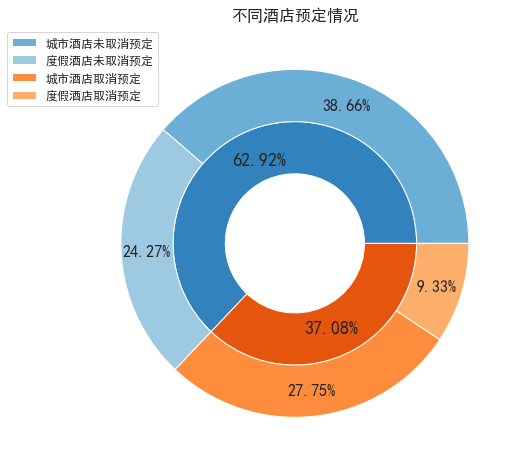

In [11]:
plt.figure(figsize=(8, 8))

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(2) * 4)
inner_colors = cmap(np.array([1, 2, 5, 6]))

w, t, at = plt.pie(data_new["is_canceled"].value_counts(),
                   autopct="%.2f%%",
                   textprops={"fontsize": 18},
                   radius=0.7,
                   wedgeprops=dict(width=0.3),
                   pctdistance=0.75,
                   colors=outer_colors)

val_array = np.array(
    (iscancel_data.loc[(iscancel_data.hotel == "城市酒店") &
                       (iscancel_data.is_canceled == 0), "count"].values,
     iscancel_data.loc[(iscancel_data.hotel == "度假酒店") &
                       (iscancel_data.is_canceled == 0), "count"].values,
     iscancel_data.loc[(iscancel_data.hotel == "城市酒店") &
                       (iscancel_data.is_canceled == 1), "count"].values,
     iscancel_data.loc[(iscancel_data.hotel == "度假酒店") &
                       (iscancel_data.is_canceled == 1), "count"].values))

w2, t2, at2 = plt.pie(val_array,
                      autopct="%.2f%%",
                      textprops={"fontsize": 16},
                      radius=1,
                      wedgeprops=dict(width=0.3),
                      pctdistance=0.85,
                      colors=inner_colors)
plt.legend(w2, ["城市酒店未取消预定", "度假酒店未取消预定","城市酒店取消预定","度假酒店取消预定"],
           loc="upper right",
           bbox_to_anchor=(0, 0, 0.2, 1),
           fontsize=12)
plt.title("不同酒店预定情况", fontsize=16)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-", color="k"),
          bbox=bbox_props,
          zorder=3,
          va="center")
plt.show()

    结论：

* 城市酒店的整体预定量远高于度假酒店，大约是度假酒店的两倍
* 从取消预定数来看，城市酒店的预定需求取消率同样高于度假酒店

#### 3.2 提前预订时间、入住时长、预订间隔、餐食预订情况

    需求：

提前预定时间对旅客是否选择取消预订的影响，用散点图+回归直线方程来可视乎来进行数据探索性分析

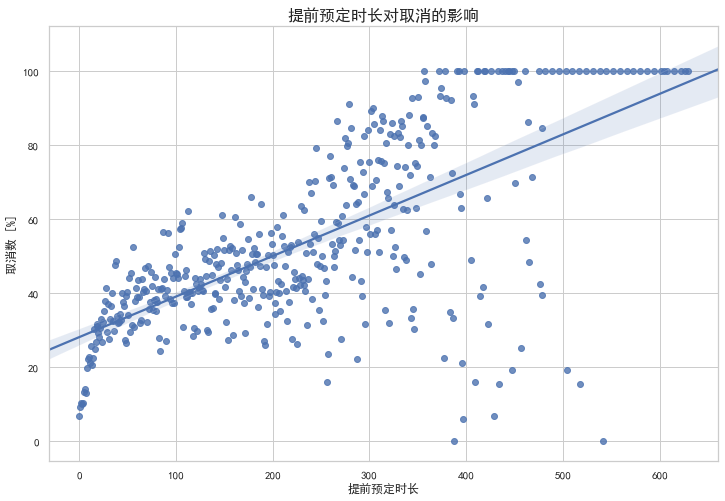

In [12]:
lead_cancel_data = data_new.groupby("lead_time")["is_canceled"].describe()
# lead_cancel_data
# 因为lead_time中值范围大且数量分布不匀，所以选取lead_time>10次的数据（<10的数据不具代表性）
lead_cancel_data_10 = lead_cancel_data[lead_cancel_data["count"]>10]
lead_cancel_data_10.reset_index(inplace=True)

x_show = list(lead_cancel_data_10["lead_time"])
y_show = list(round(lead_cancel_data_10["mean"], 4) * 100)
x, y = pd.Series(x_show, name="提前预定时长"), pd.Series(y_show, name="取消数 [%]")

plt.figure(figsize=(12, 8))
sns.regplot(x=x, y=y)
plt.title("提前预定时长对取消的影响", fontsize=16)
plt.show()

    结论：

可以明显看到：不同的提前预定时长对旅客是否取消预定有一定影响

通常，越早预订，越容易取消酒店房间预定。

    需求：

在不同酒店居住的旅客通常会选择住几天呢？我们可以使用条形图来看一下其时长的不同分布

计算出总时长：总时长=周末停留夜晚数+工作日停留夜晚数

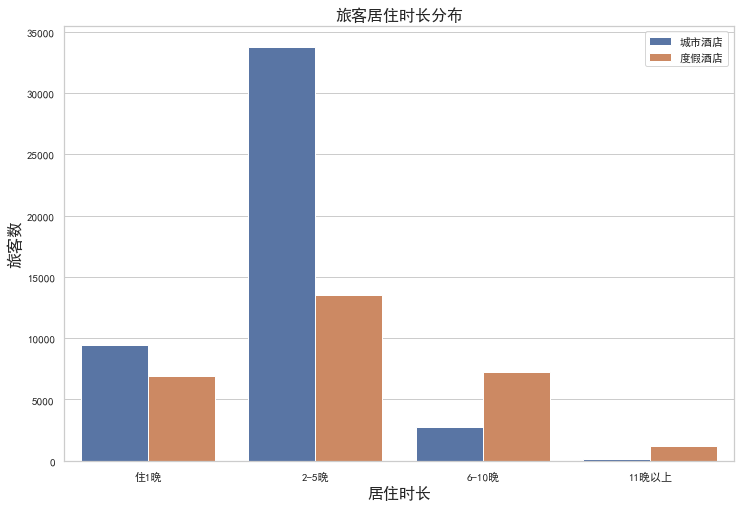

In [13]:
full_data_guests = data_new.loc[data_new["is_canceled"] == 0]

full_data_guests["total_nights"] = full_data_guests["stays_in_weekend_nights"] + full_data_guests["stays_in_week_nights"]

# 新建字段：total_nights_bin——居住时长区间
full_data_guests["total_nights_bin"] = "住1晚"
full_data_guests.loc[(full_data_guests["total_nights"]>1)&(full_data_guests["total_nights"]<=5), "total_nights_bin"] = "2-5晚"
full_data_guests.loc[(full_data_guests["total_nights"]>5)&(full_data_guests["total_nights"]<=10), "total_nights_bin"] = "6-10晚"
full_data_guests.loc[(full_data_guests["total_nights"]>10), "total_nights_bin"] = "11晚以上"

ch_nights_count = full_data_guests["total_nights_bin"][full_data_guests.hotel=="City Hotel"].value_counts()
rh_nights_count = full_data_guests["total_nights_bin"][full_data_guests.hotel=="Resort Hotel"].value_counts()

ch_nights_index = full_data_guests["total_nights_bin"][full_data_guests.hotel=="City Hotel"].value_counts().index
rh_nights_index = full_data_guests["total_nights_bin"][full_data_guests.hotel=="Resort Hotel"].value_counts().index

ch_nights_data = pd.DataFrame({"hotel": "城市酒店",
                               "nights": ch_nights_index,
                              "guests": ch_nights_count})
rh_nights_data = pd.DataFrame({"hotel": "度假酒店",
                               "nights": rh_nights_index,
                              "guests": rh_nights_count})
# 绘图数据
nights_data = pd.concat([ch_nights_data, rh_nights_data], ignore_index=True)
order = ["住1晚", "2-5晚", "6-10晚", "11晚以上"]
nights_data["nights"] = pd.Categorical(nights_data["nights"], categories=order, ordered=True)

plt.figure(figsize=(12, 8))
sns.barplot(x="nights", y="guests", hue="hotel", data=nights_data)
plt.title("旅客居住时长分布", fontsize=16)
plt.xlabel("居住时长", fontsize=16)
plt.ylabel("旅客数", fontsize=16)

plt.legend()
plt.show()

    结论：
    
在城市酒店和度假酒店中，游客基本选择都在1-5晚，而其中度假酒店中的旅客还有另外一种选择：6-10晚。

    需求：
    
预定间隔

    结论：

该数据属性列包括：酒店、是否取消预定、从预定到抵达酒店的时长、到达酒店时的年份、到达酒店时的月份、到达酒店时的周数、到达酒店时是本月第几天、待在周末晚上的时间、待在工作日晚上的时间、成人数量、儿童数量、婴儿数量、午餐、国家、市场细分、预定渠道、是否是常客、以前是否取消过、以前预定前未取消先前预定、保留房间类型、指定房间类型、从预订到入住或取消前是否变更、定金类型、预定旅行社的ID、由预定或支付的实体公司ID、在预定确认前等待时长、客人类型、平均房价、客人停车需求、是否有特殊需求、预定状态、状态更新日期

根据上述描述未发现可以直接或间接挖掘预定间隔的属性信息，因此认为根据现有数据集是不能挖掘用户行为：预定间隔。

    需求：
    
现在探索性分析餐食的选择是否会影响游客取消预定

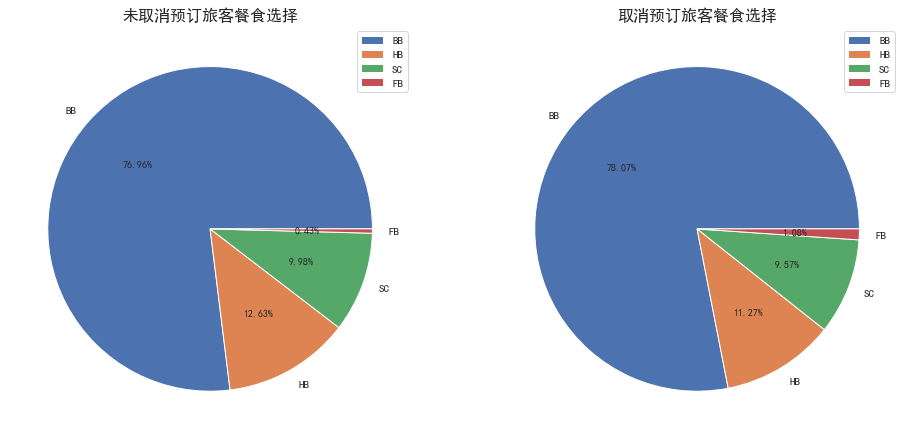

In [14]:
meal_data = data_new[["hotel", "is_canceled", "meal"]]

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.pie(meal_data.loc[meal_data["is_canceled"] == 0, "meal"].value_counts(),
        labels=meal_data.loc[meal_data["is_canceled"] ==
                             0, "meal"].value_counts().index,
        autopct="%.2f%%")
plt.title("未取消预订旅客餐食选择", fontsize=16)
plt.legend(loc="upper right")

plt.subplot(122)
plt.pie(meal_data.loc[meal_data["is_canceled"] == 1, "meal"].value_counts(),
        labels=meal_data.loc[meal_data["is_canceled"] ==
                             1, "meal"].value_counts().index,
        autopct="%.2f%%")
plt.title("取消预订旅客餐食选择", fontsize=16)
plt.legend(loc="upper right")
plt.show()

    结论：
    
取消预订旅客和未取消预订旅客有基本相同的餐食选择

#### 3.3 一年中最佳预订酒店时间

    需求：
    
为了预测分析一年中最佳预定酒店的时间，可以从人均价格入手，因为babies年龄过小，所以人均价格中未将babies带入计算

$$ \text{人均价格/晚} = \frac{adr}{adults + children} $$

查看不同月份下的平均酒店价格：

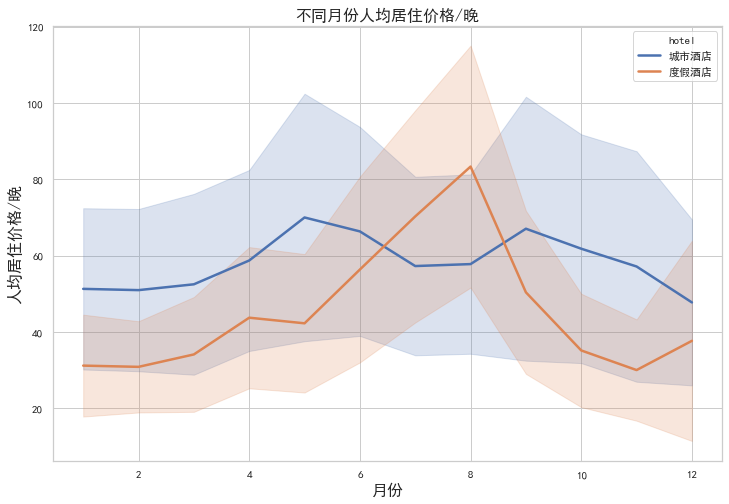

In [15]:
data_new["adr_pp"] = data_new["adr"] / (data_new["adults"] + data_new["children"])
full_data_guests = data_new.loc[data_new["is_canceled"] == 0]

room_prices = full_data_guests[["hotel", "reserved_room_type", "adr_pp"]].sort_values("reserved_room_type")
room_price_monthly = full_data_guests[["hotel", "arrival_date_month", "adr_pp"]]

ordered_months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
month_che = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for en, che in zip(ordered_months, month_che):
    room_price_monthly["arrival_date_month"].replace(en, che, inplace=True)
    
room_price_monthly.sort_values(by="arrival_date_month", inplace=True)
room_price_monthly["arrival_date_month"] = pd.Categorical(room_price_monthly["arrival_date_month"], categories=month_che, ordered=True)
room_price_monthly["hotel"].replace("City Hotel", "城市酒店", inplace=True)
room_price_monthly["hotel"].replace("Resort Hotel", "度假酒店", inplace=True)

plt.figure(figsize=(12, 8))
sns.lineplot(x="arrival_date_month", y="adr_pp", hue="hotel", data=room_price_monthly, hue_order=["城市酒店", "度假酒店"], ci="sd", size="hotel", sizes=(2.5, 2.5))
plt.title("不同月份人均居住价格/晚", fontsize=16)
plt.xlabel("月份", fontsize=16)
plt.ylabel("人均居住价格/晚", fontsize=16)
plt.show()

    结论：
    
* 城市酒店全年人均每晚价格波动较小，基本与全年预定量情况变化趋势一致
* 度假酒店人均每晚价格随月份波动较大，其中8月价格最高
* 全年最佳预订酒店时间：城市酒店12-2月，度假酒店1-2月

### 4. 利用Logistic预测酒店预订

data.corr()对样本特征进行相关性计算，给出了任意两个变量之间的相关系数

In [16]:
# 将分类数据进行标签化处理，方便进行后续的相关性计算
le = LabelEncoder()
data_copy=data_new.copy()
data_copy['agent']= data_copy['agent'].astype(int)
data_copy['country']= data_copy['country'].astype(str)

data_copy['hotel'] = le.fit_transform(data_copy['hotel'])
data_copy['arrival_date_month'] = le.fit_transform(data_copy['arrival_date_month'])
data_copy['meal'] = le.fit_transform(data_copy['meal'])
data_copy['country'] = le.fit_transform(data_copy['country'])
data_copy['market_segment']= le.fit_transform(data_copy['market_segment'])
data_copy['distribution_channel']=le.fit_transform(data_copy['distribution_channel'])
data_copy['is_repeated_guest'] = le.fit_transform(data_copy['is_repeated_guest'])
data_copy['reserved_room_type'] = le.fit_transform(data_copy['reserved_room_type'])
data_copy['assigned_room_type'] = le.fit_transform(data_copy['assigned_room_type'])
data_copy['deposit_type'] = le.fit_transform(data_copy['deposit_type'])
data_copy['agent'] = le.fit_transform(data_copy['agent'])
data_copy['customer_type'] = le.fit_transform(data_copy['customer_type'])
data_copy['reservation_status'] = le.fit_transform(data_copy['reservation_status'])

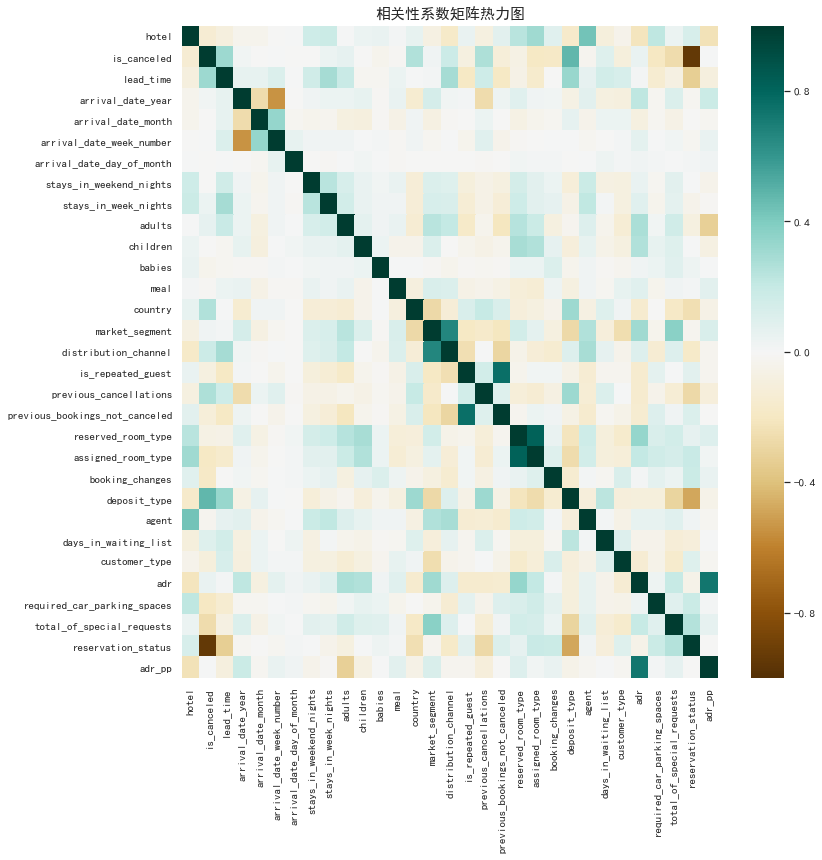

In [17]:
data_corr=data_copy.corr(method='spearman')

plt.figure(figsize=(12, 12))
sns.heatmap(data_corr,cmap='BrBG', vmin=-1, vmax=1)
plt.title('相关性系数矩阵热力图',size=15, weight='bold')
plt.show()

In [18]:
np.abs(data_corr['is_canceled']).sort_values(ascending=False)

is_canceled                       1.000000
reservation_status                0.942700
deposit_type                      0.477106
lead_time                         0.316448
previous_cancellations            0.270316
country                           0.260578
total_of_special_requests         0.258743
required_car_parking_spaces       0.197604
assigned_room_type                0.188025
booking_changes                   0.184299
distribution_channel              0.173747
hotel                             0.137082
previous_bookings_not_canceled    0.115395
customer_type                     0.099376
days_in_waiting_list              0.098417
is_repeated_guest                 0.083745
reserved_room_type                0.068031
adults                            0.065668
adr                               0.049927
stays_in_week_nights              0.041431
babies                            0.034390
market_segment                    0.026340
agent                             0.024745
arrival_dat

    结论：
    
与订单取消有一定相关性的前三个因素为预付款方式，提前下单时间以及客户之前订单的取消次数（因为reservation_status该字段本身就表示了该订单是否被取消，故排除该项）

In [19]:
# 为了使模型更通用并防止泄漏，排除了一些列
num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]
#分离特征和预测值
features = num_features + cat_features
X = data_new.drop(["is_canceled"], axis=1)[features]
y = data_new["is_canceled"]

In [20]:
#预处理数值特征：
#对于大多数num cols，除了日期，0是最符合逻辑的填充值
#这里没有日期遗漏。
num_transformer = SimpleImputer(strategy="constant")

# 分类特征的预处理：
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# 数值和分类特征的束预处理：
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])

# 定义要测试的模型：
base_models = [("LR_model", LogisticRegression(random_state=42,n_jobs=-1))]

In [21]:
# 将数据分成“kfold”部分进行交叉验证
# 使用shuffle确保数据的随机分布：
kfolds = 4  # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

#对模型进行预处理、拟合、预测和评分：
for name, model in base_models:
    #将数据和模型的预处理打包到管道中：
    model_steps = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    
    #获取模型的交叉验证分数：
    cv_results = cross_val_score(model_steps, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
    # output:
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    print(f"{name} cross validation accuarcy score: {mean_score} min: {min_score}, max: {max_score}")

LR_model cross validation accuarcy score: 0.8081 min: 0.8076, max: 0.8085


### 5. 挖掘其他问题

    需求：

查看月度人流量

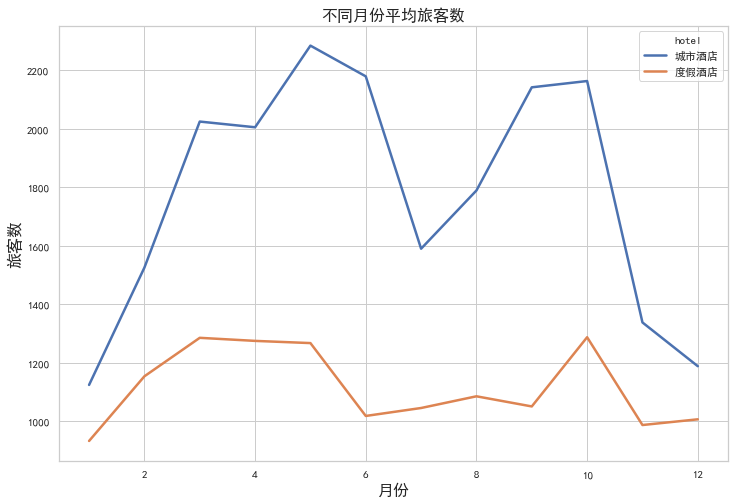

In [22]:
# 查看月度人流量
rh_bookings_monthly = full_data_guests[
    full_data_guests.hotel == "Resort Hotel"].groupby(
        "arrival_date_month")["hotel"].count()
ch_bookings_monthly = full_data_guests[
    full_data_guests.hotel == "City Hotel"].groupby(
        "arrival_date_month")["hotel"].count()

rh_bookings_data = pd.DataFrame({
    "arrival_date_month":
    list(rh_bookings_monthly.index),
    "hotel":
    "度假酒店",
    "guests":
    list(rh_bookings_monthly.values)
})
ch_bookings_data = pd.DataFrame({
    "arrival_date_month":
    list(ch_bookings_monthly.index),
    "hotel":
    "城市酒店",
    "guests":
    list(ch_bookings_monthly.values)
})
full_booking_monthly_data = pd.concat([rh_bookings_data, ch_bookings_data],
                                      ignore_index=True)

ordered_months = [
    "January", "February", "March", "April", "May", "June", "July", "August",
    "September", "October", "November", "December"
]
month_che = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for en, che in zip(ordered_months, month_che):
    full_booking_monthly_data["arrival_date_month"].replace(en,
                                                            che,
                                                            inplace=True)

full_booking_monthly_data["arrival_date_month"] = pd.Categorical(
    full_booking_monthly_data["arrival_date_month"],
    categories=month_che,
    ordered=True)

full_booking_monthly_data.loc[
    (full_booking_monthly_data["arrival_date_month"] == 7) |
    (full_booking_monthly_data["arrival_date_month"] == 8), "guests"] /= 3
full_booking_monthly_data.loc[~(
    (full_booking_monthly_data["arrival_date_month"] == 7) |
    (full_booking_monthly_data["arrival_date_month"] == 8)), "guests"] /= 2
plt.figure(figsize=(12, 8))
sns.lineplot(x="arrival_date_month",
             y="guests",
             hue="hotel",
             hue_order=["城市酒店", "度假酒店"],
             data=full_booking_monthly_data,
             size="hotel",
             sizes=(2.5, 2.5))
plt.title("不同月份平均旅客数", fontsize=16)
plt.xlabel("月份", fontsize=16)
plt.ylabel("旅客数", fontsize=16)
plt.show()

    结论：
    
* 城市酒店全年有两个入住高峰期，5-6月以及9-10月，7月预定量出现明显下降，12-1月入住量全年最低
* 度假酒店各月份预定量均小于城市酒店，度假酒店10月及3-5月为全年入住高峰期，全年预定量波动幅度较小

    需求：
    
查看用户国家

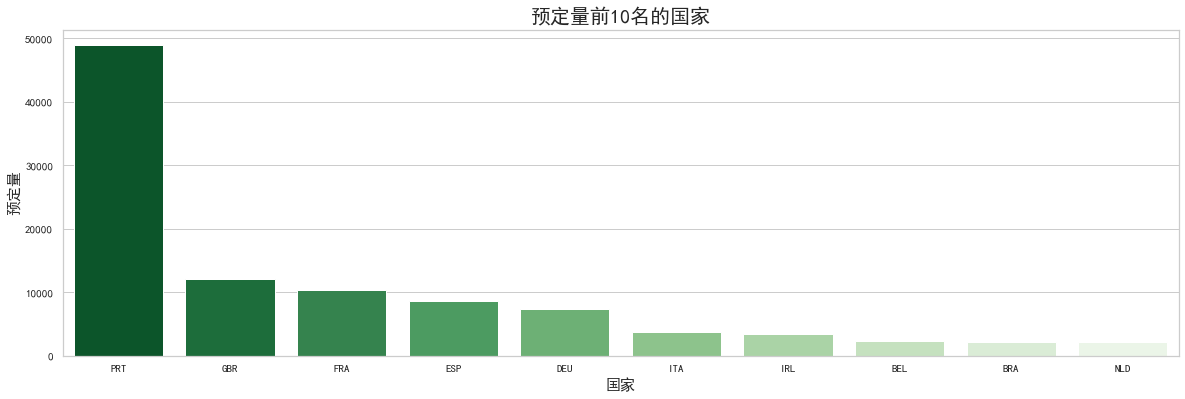

In [23]:
plt.figure(figsize=(20,6))
sns.countplot(x='country',data=data_new,order=data_new['country'].value_counts().iloc[:10].index,palette='Greens_r')
plt.title('预定量前10名的国家',fontsize=20)
plt.xlabel('国家',fontsize=15)
plt.ylabel('预定量',fontsize=15)
plt.show()

In [24]:
data_new['country'].value_counts().iloc[:10]/data_new['country'].value_counts().sum()

PRT    0.410712
GBR    0.101669
FRA    0.087249
ESP    0.071806
DEU    0.061111
ITA    0.031549
IRL    0.028303
BEL    0.019646
BRA    0.018639
NLD    0.017641
Name: country, dtype: float64

    结论：
    
* 在所有未取消预订客户中，葡萄牙本国的预定量最多，达到总预定量的28%
* 其后依次是英国，法国、西班牙、德国，前5名均为欧洲国家

    需求：
    
探索性分析预付款方式对订单取消的影响

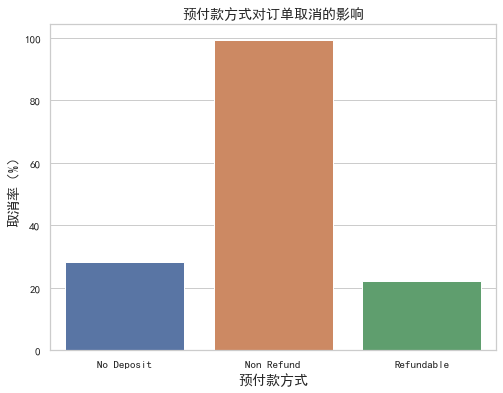

In [25]:
deposit_data = data_new.groupby('deposit_type')['is_canceled'].describe()

plt.figure(figsize=(8, 6))
sns.barplot(x=deposit_data.index, y=deposit_data['mean'] * 100)
plt.title('预付款方式对订单取消的影响', fontsize=14)
plt.xlabel('预付款方式', fontsize=14)
plt.ylabel('取消率（%）', fontsize=14)
plt.show()

    结论：
    
No Deposit：无预付保证金

Non Refund：房价全额提前预付，取消不退款

Refundable：部分房价预付，取消可退款

* 全额预付房费且不能退款的客户几乎100%取消了房间预订，与正常逻辑存在较大偏差，猜测可能是数据本身存在问题或标签类别有误